In [6]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
import matplotlib.pyplot as plt

In [14]:
class TeluguOCRDataset(Dataset):
    def __init__(self, image_file_path, label_file_path):
        self.image_file_path = image_file_path
        self.label_file_path = label_file_path
    
    def __len__(self):
        return len(os.listdir(self.image_file_path))

    def __getitem__(self, index):
        image = torch.load(os.path.join(self.image_file_path, "Image"+str(index) + '.pt'))
        label = torch.load(os.path.join(self.label_file_path, "Label"+str(index) + '.pt'))
        return image, label, label.shape[0]

In [17]:
acchulu = ['అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ౠ', 'ఌ', 'ౡ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'అం', 'అః']
hallulu = ['క', 'ఖ', 'గ', 'ఘ', 'ఙ',
           'చ', 'ఛ', 'జ', 'ఝ', 'ఞ',
           'ట', 'ఠ', 'డ', 'ఢ', 'ణ',
           'త', 'థ', 'ద', 'ధ', 'న',
           'ప', 'ఫ', 'బ', 'భ', 'మ',
           'య', 'ర', 'ల', 'వ', 'శ', 'ష', 'స', 'హ', 'ళ', 'క్ష', 'ఱ']
vallulu = ['ా', 'ి', 'ీ', 'ు' , 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', 'ం', 'ః', 'ఁ', 'ౕ', 'ౖ', 'ౢ' ]
connector = ['్']
numbers = ['౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯']
splcharacters= [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')',
              '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[',
              '\\', ']', '^', '_', '`', '{', '|', '}', '~', '1','2', '3', '4', '5', '6', '7', '8', '9', '0', 'ఽ']
spl = splcharacters + numbers

bases = acchulu + hallulu + spl
vms = vallulu
cms = hallulu

print("Bases: ", len(bases))
print("Vms: ", len(vms))
print("Cms: ", len(cms))

characters = bases+vms+cms+connector

base_mapping = {}
i = 2
for x in bases:
  base_mapping[x] = i
  i+=1

vm_mapping = {}
i = 2
for x in vms:
  vm_mapping[x] = i
  i+=1

cm_mapping = {}
i = 2
for x in cms:
  cm_mapping[x] = i
  i+=1

  
# creates a list of ductionaries with each dictionary reporesenting a term
def wordsDicts(s):
  List = []
  for i in range(len(s)):
    x = s[i]
    prev = ''
    if i > 0: prev = s[i-1]
    #----------------------------------is it a base term-----------------------
    if((x in acchulu or x in hallulu)  and prev != connector[0]):
      List.append({})
      List[-1]['base'] = x
    #----------------------------if it is a consonant modifier-----------------
    elif x in hallulu and prev == connector[0]:
      if(len(List) == 0):
        print(x)
      if('cm' not in List[-1]): List[-1]['cm'] = []
      List[len(List)-1]['cm'].append(x)

      #---------------------------if it is a vowel modifier--------------------
    elif x in vallulu:
      if(len(List) == 0):
        print(x)

      if('vm' not in List[-1]): List[-1]['vm'] = []
      List[len(List)-1]['vm'].append(x)

      #----------------------------it is a spl character-----------------------
    elif x in spl:
      List.append({})
      List[len(List)-1]['base'] = x
    else:
      continue
  return List

def index_encoding(s):
  List = wordsDicts(s)
  onehot = []
  for i in range(len(List)):
    D = List[i]
    onehotbase=  [1]
    onehotvm1 =  [1]
    onehotvm2 =  [1]
    onehotvm3 =  [1]
    onehotvm4 =  [1]
    onehotcm1 =  [1]
    onehotcm2 =  [1]
    onehotcm3 =  [1]
    onehotcm4 =  [1]


    onehotbase[0] = base_mapping[D['base']]

    it = 1
    if('vm' in D):
      for j in D['vm']:
        if it == 1:
          onehotvm1[0] = vm_mapping[j]
        elif it == 2:
          onehotvm2[0] = vm_mapping[j]
        elif it == 3:
          onehotvm3[0] = vm_mapping[j]
        elif it == 4:
          onehotvm4[0] = vm_mapping[j]
        it += 1
    
    it = 1
    if('cm' in D):
      for j in D['cm']:
        if it == 1:
          onehotcm1[0] = cm_mapping[j]
        elif it == 2:
          onehotcm2[0] = cm_mapping[j]
        elif it == 3:
          onehotcm3[0] = cm_mapping[j]
        elif it == 4:
          onehotcm4[0] = cm_mapping[j]
        it += 1
    onehoti = onehotbase + onehotvm1 + onehotvm2 + onehotvm3 + onehotvm4 + onehotcm1 + onehotcm2 + onehotcm3 + onehotcm4 #size 110 + 4*21 + 4*38 = 346
    onehot.append(onehoti)
  return onehot

def index_decoder(List):
  x = ""
  for onehoti in List:
    if onehoti[0] > 1:
      x += bases[onehoti[0]-2]

    if onehoti[5] > 1:
      x += connector[0]
      x += cms[onehoti[5]-2]
    if onehoti[6] > 1:
      x += connector[0]
      x += cms[onehoti[6]-2]
    if onehoti[7] > 1:
      x += connector[0]
      x += cms[onehoti[7]-2]
    if onehoti[8] > 1:
      x += connector[0]
      x += cms[onehoti[8]-2]

    if onehoti[1] > 1:
      x += vms[onehoti[1]-2]
    if onehoti[2] > 1:
      x += vms[onehoti[2]-2]
    if onehoti[3] > 1:
      x += vms[onehoti[3]-2]
    if onehoti[4] > 1:
      x += vms[onehoti[4]-2]
  return x

Bases:  108
Vms:  19
Cms:  36


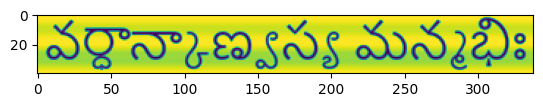

వర్ధాన్కాణ్వస్య మన్మభిః


In [19]:
dataset = TeluguOCRDataset("/home/ocr/teluguOCR/Dataset/Cropped_Data/Images", "/home/ocr/teluguOCR/Dataset/Cropped_Data/Labels")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

image, label, label_length = next(iter(dataloader))
plt.imshow(image[0])
plt.show()

print(index_decoder(label[0]))